<a href="https://colab.research.google.com/github/sayan0506/Task-2-Internship/blob/main/IIITD_assignment_task_2_test_script.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Training Central Dataset**

Assignment link: 

https://docs.google.com/document/d/1WQHJ2KpImvA1l5QOkLQjaECOSKMiT3jp_UKH2p1zk_c/edit

In [1]:
# install keras livelossplot
!pip -q install livelossplot

# install wandb
!pip install --upgrade wandb

     |████████████████████████████████| 2.1MB 5.5MB/s 
     |████████████████████████████████| 102kB 7.1MB/s 
     |████████████████████████████████| 133kB 14.4MB/s 
     |████████████████████████████████| 163kB 18.6MB/s 
     |████████████████████████████████| 71kB 7.7MB/s 
  Created wheel for subprocess32: filename=subprocess32-3.5.4-cp37-none-any.whl size=6489 sha256=0fda36a30f66a5c0c907100c94e93de4ce5dde505cd1a78a6f1df545f9b0663b
  Stored in directory: /root/.cache/pip/wheels/68/39/1a/5e402bdfdf004af1786c8b853fd92f8c4a04f22aad179654d1
  Created wheel for pathtools: filename=pathtools-0.1.2-cp37-none-any.whl size=8786 sha256=eacee5d4af827111ca2c71b8fc74ee0f7a4af3bdb9ea92101c0ce31a34874152
  Stored in directory: /root/.cache/pip/wheels/0b/04/79/c3b0c3a0266a3cb4376da31e5bfe8bba0c489246968a68e843
Successfully built subprocess32 pathtools


# **Import Modules**

In [38]:
import zipfile
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import pandas as pd


import tensorflow as tf
from keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# **Environment Setup**
**Improve Reproducibility**

In [3]:
# improve reproducibility and make it more deterministic
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
random.seed(hash("setting random seeds") % 2**32 - 1)
np.random.seed(hash("improves reproducibility") % 2**32 - 1)
tf.random.set_seed(hash("by rmoving stochasticity")% 2**32 -1)

**Setup wandb environment**

In [4]:
import wandb
from wandb.keras import WandbCallback

# authorize
# wandb.login()

# **Download and unzipping the Dataset**

[Dropbox dataset link](https://www.dropbox.com/s/pan6mutc5xj5kj0/trainPart1.zip)

In [5]:
!wget https://www.dropbox.com/s/pan6mutc5xj5kj0/trainPart1.zip

--2021-04-06 16:23:29--  https://www.dropbox.com/s/pan6mutc5xj5kj0/trainPart1.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.82.18, 2620:100:6032:18::a27d:5212
Connecting to www.dropbox.com (www.dropbox.com)|162.125.82.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/pan6mutc5xj5kj0/trainPart1.zip [following]
--2021-04-06 16:23:29--  https://www.dropbox.com/s/raw/pan6mutc5xj5kj0/trainPart1.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucdbd0361807a5bff417513867d1.dl.dropboxusercontent.com/cd/0/inline/BME15Yi92ORCrtEGviZ2oev6zvMTGhDIOQoR_HyXZzMvX1s-UFXepn_V8v0qc4w8kch_55_NgVigOwKTmDWHkpZ8bcupcBo29ULYl8LeIcEhCqWMLGD_xjoAk6KQGsKUHrNPhlD7DEZSIIpyybJIWMAF/file# [following]
--2021-04-06 16:23:29--  https://ucdbd0361807a5bff417513867d1.dl.dropboxusercontent.com/cd/0/inline/BME15Yi92ORCrtEGviZ2oev6zvMTGhDIOQoR_HyXZzMvX1s-UFXepn_V8v0qc4w8kch_55_NgVigOwKTm

## Unzipping

In [6]:
# defining unzipping function
def unzip(zip_file, content_dir):
  if not os.path.isdir(content_dir):
    os.mkdir(content_dir)

  # unzipping
  with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall(content_dir)

In [7]:
# zipfile path
zip_file = '/content/trainPart1.zip'

# content directory
content_dir = 'master_data'

# calling unzip
unzip(zip_file, content_dir)

# **Data Inspection**

In [8]:
# master directory path
img_dir = '/content/master_data/train'

# classifiers list
print(f'List of classifiers\n{sorted(os.listdir(img_dir))}')
print(f'Total {len(os.listdir(img_dir))} classifiers are there')


List of classifiers
['Sample001', 'Sample002', 'Sample003', 'Sample004', 'Sample005', 'Sample006', 'Sample007', 'Sample008', 'Sample009', 'Sample010', 'Sample011', 'Sample012', 'Sample013', 'Sample014', 'Sample015', 'Sample016', 'Sample017', 'Sample018', 'Sample019', 'Sample020', 'Sample021', 'Sample022', 'Sample023', 'Sample024', 'Sample025', 'Sample026', 'Sample027', 'Sample028', 'Sample029', 'Sample030', 'Sample031', 'Sample032', 'Sample033', 'Sample034', 'Sample035', 'Sample036', 'Sample037', 'Sample038', 'Sample039', 'Sample040', 'Sample041', 'Sample042', 'Sample043', 'Sample044', 'Sample045', 'Sample046', 'Sample047', 'Sample048', 'Sample049', 'Sample050', 'Sample051', 'Sample052', 'Sample053', 'Sample054', 'Sample055', 'Sample056', 'Sample057', 'Sample058', 'Sample059', 'Sample060', 'Sample061', 'Sample062']
Total 62 classifiers are there


## Defining the classifiers

From the dataset we are adding custom labels to the classifiers. We find that each of the individual folder consist of unique classes.

In [9]:
class_ids = [int(id.split('Sample')[1]) for id in sorted(os.listdir(img_dir))]
print(f'We are representing the {len(class_ids)} class ids with the ids {class_ids[0]} to {class_ids[-1]} respectively, also for prediction')
#for cls in class_ids: print(cls)

We are representing the 62 class ids with the ids 1 to 62 respectively, also for prediction


## Data Visualization

 Defining the function to visualize random sample from each image class

In [10]:
def vis_images(img_dir, class_ids):
  '''
  Visualizing random samples for each class
  '''
  # no of image in each row
  cols = 9
  rows = int(np.ceil(len(os.listdir(img_dir))/cols))
  # samples left for the last row, the remainders
  end_count = len(os.listdir(img_dir))%cols
  
  # defining the figure to visualize
  fig = plt.figure(figsize = (30,25))
  fig.suptitle('Visualize samples from individual classes', fontsize = 16)
  fig.tight_layout()
  fig.subplots_adjust(top = 0.95)
  
  for id, folder in enumerate(sorted(os.listdir(img_dir))):

    # fetching random image sample
    id_path = os.path.join(img_dir,folder)
    img_sample = random.choice(os.listdir(id_path))
    img_path = os.path.join(id_path, img_sample)
    img = plt.imread(img_path)

    # visualize
    fig.add_subplot(rows, cols, id+1)
    plt.imshow(img)
    plt.xlabel(f'Class id: {class_ids[id]}')
    
  plt.show()


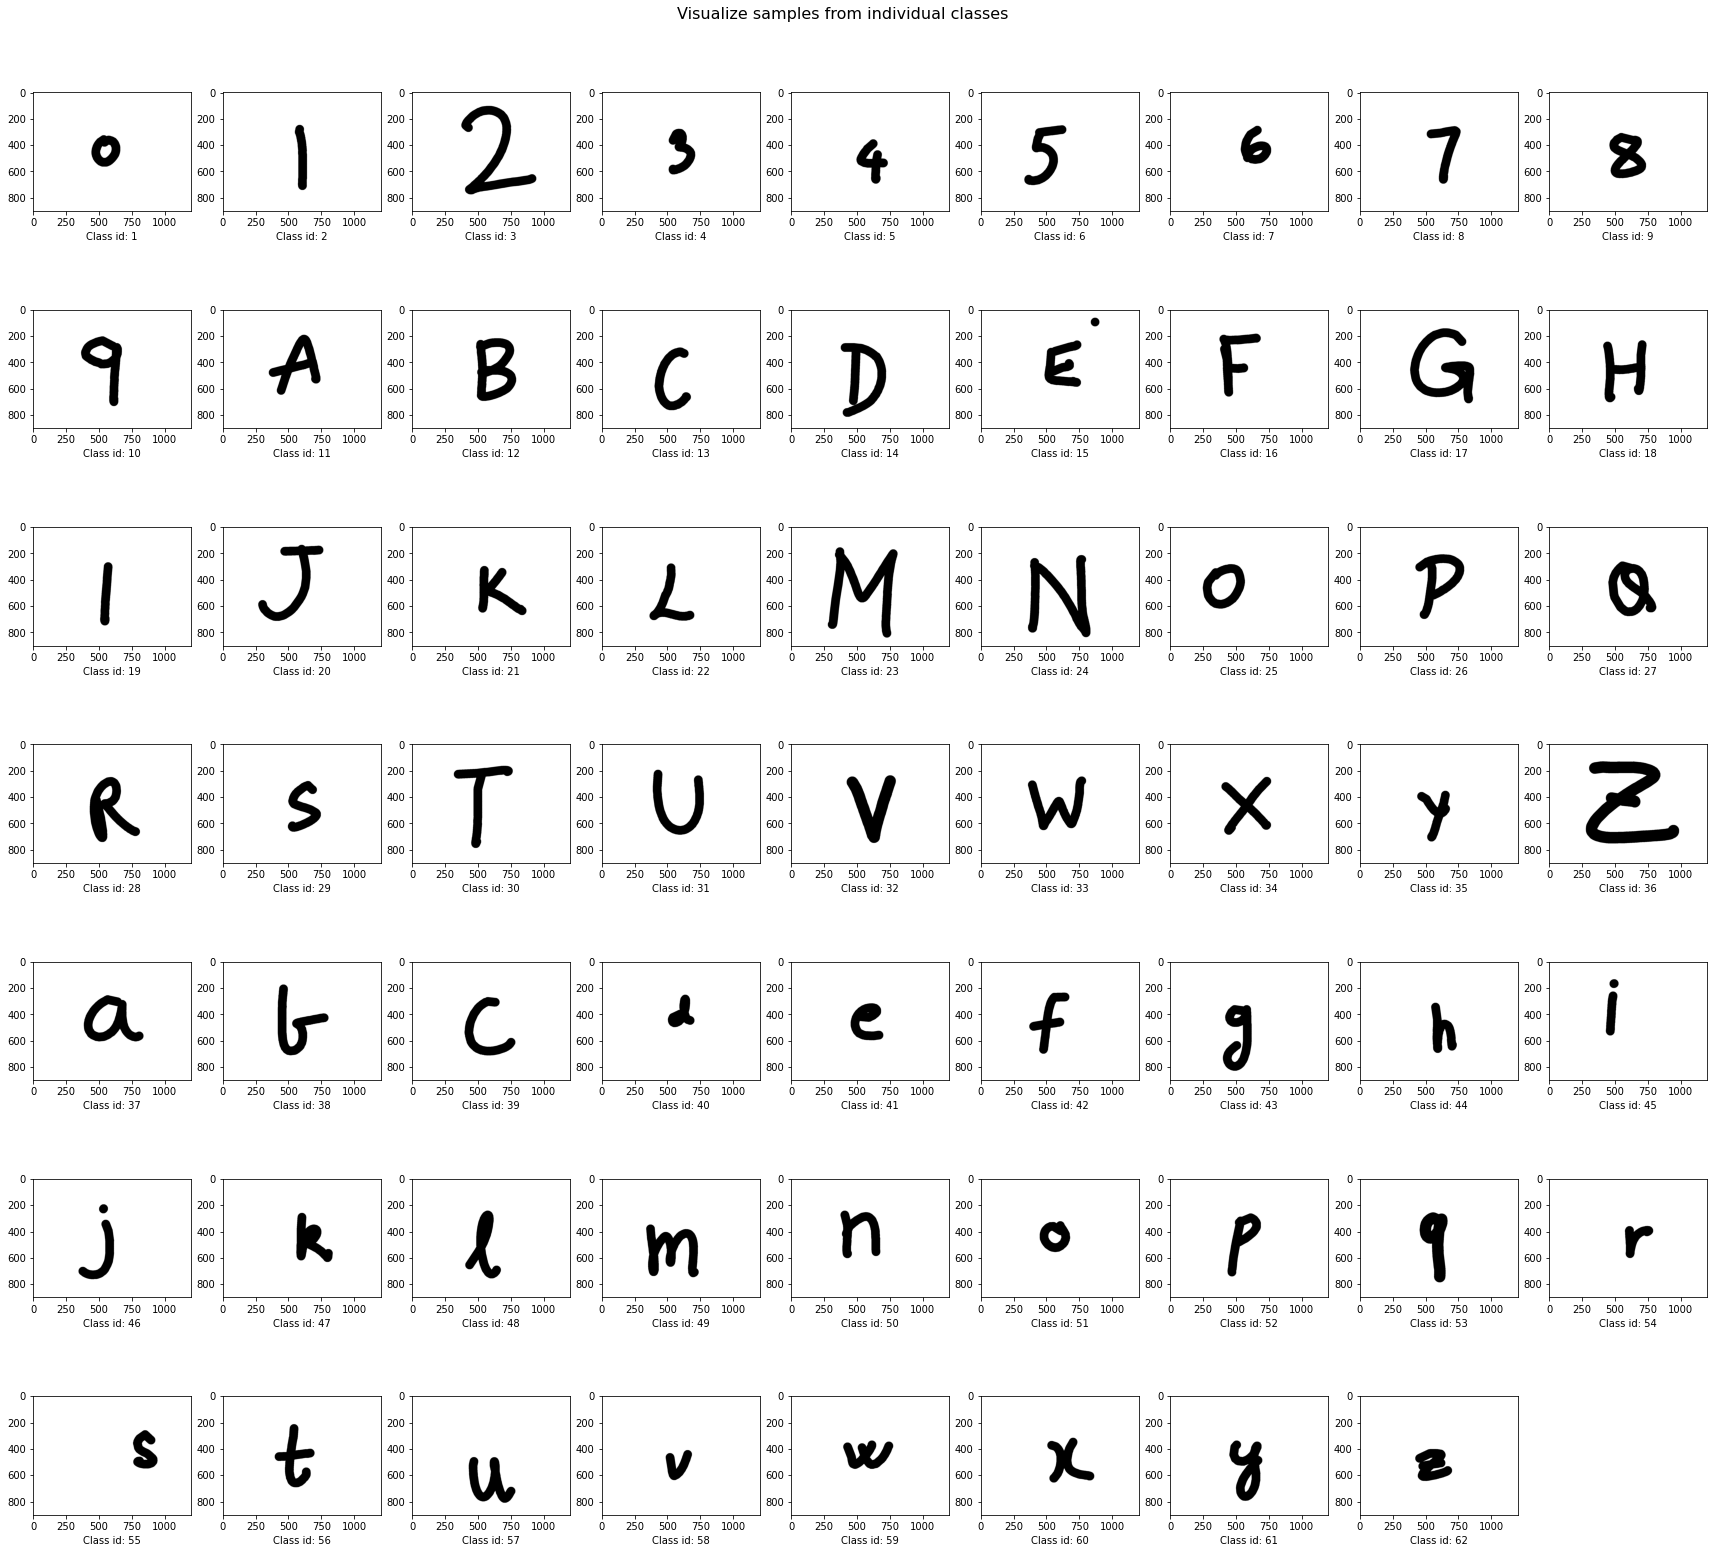

In [11]:
vis_images(img_dir, class_ids)

## Data Loading

**Defining function for creating image array
 and labels list from the folder**

In [12]:
def convert_img_to_array(image_path):
  try:
    img = plt.imread(image_path)
    if img is not None:
      return img_to_array(img)
    else:
      return np.array([])
  
  except Exception as e:
    print(f'Error {e}')
    return None

**Defining function for creating image array and labels list from the folder**

In [16]:
def fetch_img(img_dir):
  samples_list = sorted(os.listdir(img_dir))
  classifiers_path = [os.path.join(img_dir, path) for path in sorted(os.listdir(img_dir))]
  print(f'Classifiers directory names {classifiers_path}')
  # image array list
  image_list = []
  # image labels list
  label_list = []
  # label dataframe
  label_df = pd.DataFrame(columns = sorted(os.listdir(img_dir)))
  # image dataframe
  img_df = pd.DataFrame(columns = ['Image', 'Shape', 'Label'])
  try:
    print('\n[INFO] Acquiring Image Informations ...')
    # total sample count
    sample_count = 0
    for sr, c_path in enumerate(classifiers_path):
      #print(f'[INFO] Processing {samples_list[sr]}')
      path_list = os.listdir(c_path)
      # removing .DS_store files from list if present
      for cs in path_list:
        if cs == '.DS_store':
          path_list.remove(cs)
      
      # categorical count
      count = 0
      for class_sample in path_list:
        class_sample_path = os.path.join(c_path, class_sample)
        if class_sample_path.endswith(".jpg")==True or class_sample_path.endswith(".JPG")==True or class_sample_path.endswith(".png")==True:
          img = convert_img_to_array(class_sample_path)
          #image_list.append(img)
          #label_list.append(class_ids[sr])
          img_df.loc[sample_count, 'Image'], img_df.loc[sample_count, 'Label'] = class_sample, class_ids[sr]
          img_df.loc[sample_count, 'Shape'] = img.shape
          count += 1
          sample_count += 1

      print('Done!')
      label_df.loc[0, samples_list[sr]] = count

    return label_df, img_df
    #image_list, label_list, 

  except Exception as e:
    print(f'Error {e}')
    return None 

In [14]:
ldf, img_df = fetch_img(img_dir)

Classifiers directory names ['/content/master_data/train/Sample001', '/content/master_data/train/Sample002', '/content/master_data/train/Sample003', '/content/master_data/train/Sample004', '/content/master_data/train/Sample005', '/content/master_data/train/Sample006', '/content/master_data/train/Sample007', '/content/master_data/train/Sample008', '/content/master_data/train/Sample009', '/content/master_data/train/Sample010', '/content/master_data/train/Sample011', '/content/master_data/train/Sample012', '/content/master_data/train/Sample013', '/content/master_data/train/Sample014', '/content/master_data/train/Sample015', '/content/master_data/train/Sample016', '/content/master_data/train/Sample017', '/content/master_data/train/Sample018', '/content/master_data/train/Sample019', '/content/master_data/train/Sample020', '/content/master_data/train/Sample021', '/content/master_data/train/Sample022', '/content/master_data/train/Sample023', '/content/master_data/train/Sample024', '/content/m

## Target Distribution in the Dataset

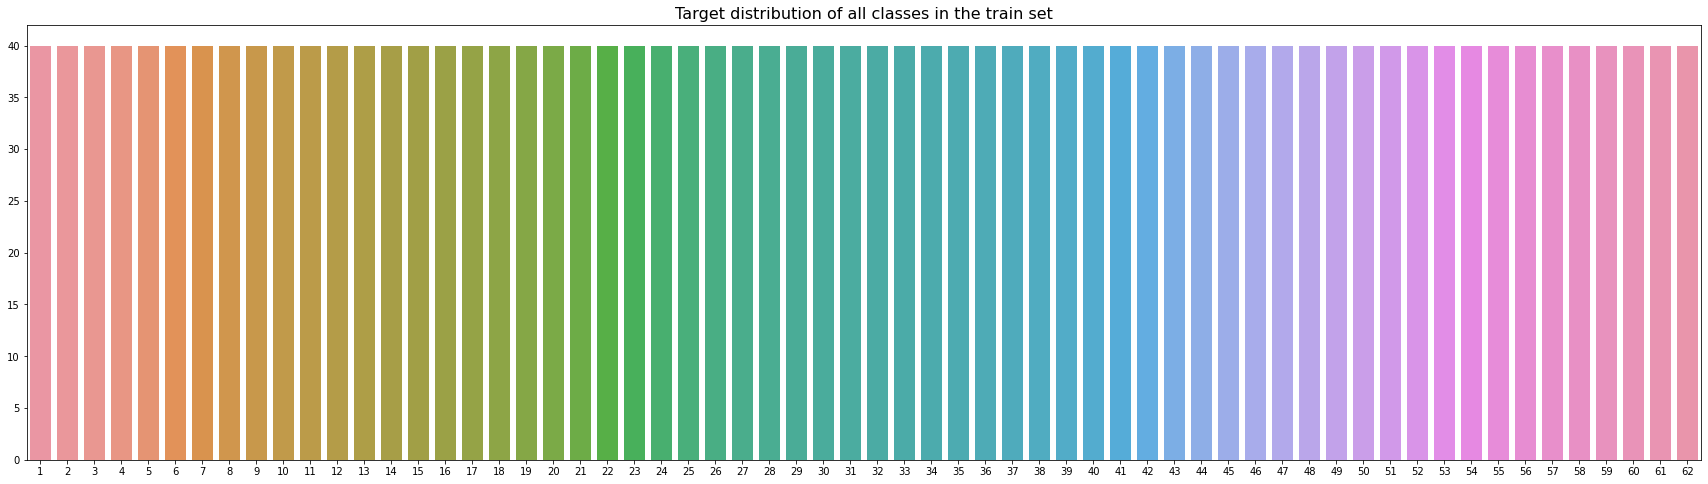

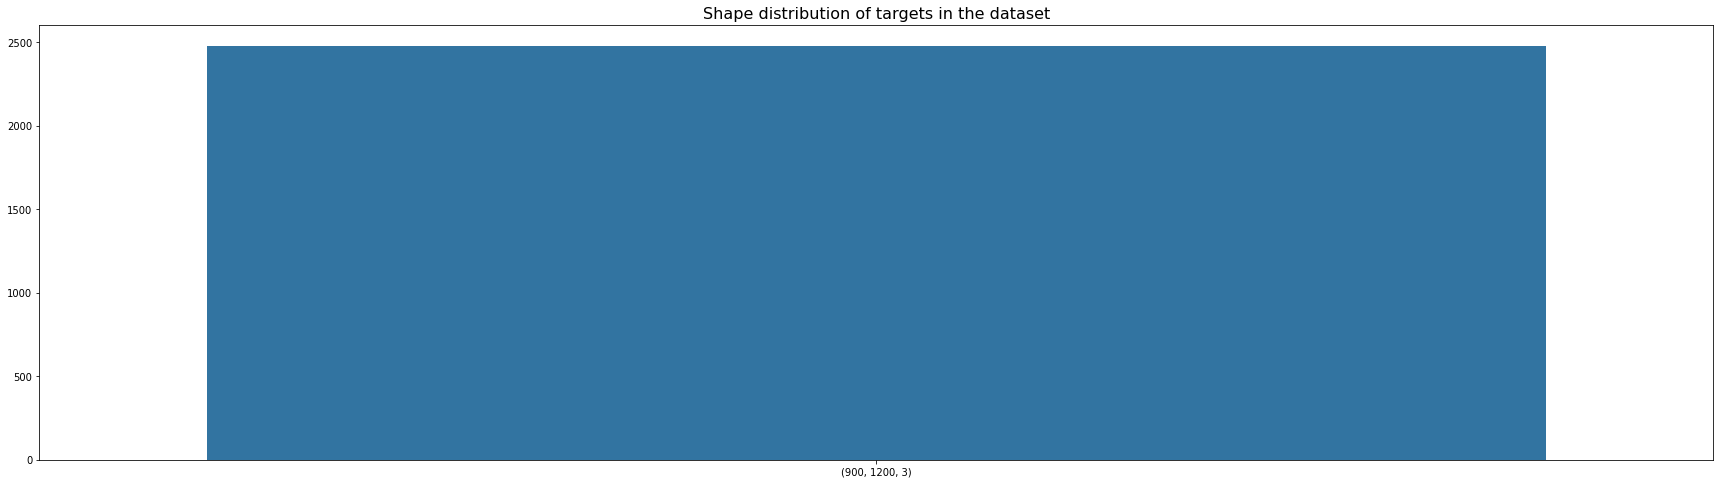

In [23]:
def distribution_vis(counts_series_train, label):
  '''
  Target data distribution in the train data
  '''
  fig = plt.figure(figsize=(30,8))
  sns.barplot(x = counts_series_train.index, y = counts_series_train.values)
  plt.title(label, fontsize = 16)

# returns pandas series with classes as keys and count as values fo train set
target_counts_train = img_df['Label'].value_counts()

# shape analysis for train set
shape_counts_train = img_df['Shape'].value_counts()

# visualize target distribution
distribution_vis(target_counts_train, label = 'Target distribution of all classes in the train set')

# visualize the shape distribution
distribution_vis(shape_counts_train, label = 'Shape distribution of targets in the dataset')

**Conclusion:**

* From the above analysis, the distribution of all the classes in the datasets are equal, i.e 40 samples for each class.
* Also, the shapes of all the samples across the dataset are equal to (900,1200,3)


# Data Pre-processing

Discussion:

Based on the target data to be tested that is the MNIST data, following pre-processing steps are used
1. Rescaing
2. Resizing(Interpolation technique check needed) to target size (28,28)
3. Changing color mode to reduce number of channels.
4. Creating Batches

## Interpolation check

Here we will compare between two of the popular interpolation methods with target size (28,28)

**1. Bilinear spline**, 
**2. Bicubic spline**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 0, 'After Bicubic Interpolation')

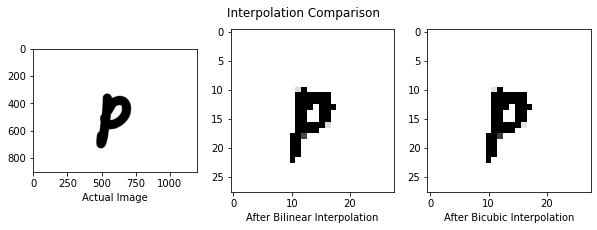

In [37]:
# obtain a random category from the dataset
img_cat = random.choice(os.listdir(img_dir))
# folder path
cat_path = os.path.join(img_dir,img_cat)

# obtain random sample corresponding to the category
img_name = random.choice(os.listdir(cat_path))
# image path
img_path = os.path.join(cat_path, img_name)
# obtain the image
img = plt.imread(img_path)

# bilinear spline interpolation 
img_linear = tf.keras.preprocessing.image.smart_resize(img, size = (28,28),
                                                       interpolation='bilinear')

# bicubic spline interpolation 
img_cubic = tf.keras.preprocessing.image.smart_resize(img, size = (28,28),
                                                       interpolation='bicubic')


fig = plt.figure(figsize = (10,3))
fig.suptitle('Interpolation Comparison')

# before interpolation
fig.add_subplot(131)
plt.imshow(img)
plt.xlabel('Actual Image')

# after bilinear
fig.add_subplot(132)
plt.imshow(img_linear)
plt.xlabel('After Bilinear Interpolation')

# after bicubic
fig.add_subplot(133)
plt.imshow(img_cubic)
plt.xlabel('After Bicubic Interpolation')


**Conclusion:** On going through several samples we can find Bicubic Interpolation is the suitable here.

## Image pre-peocessing using keras ImageDataGenerator

**Steps**

1. Test 1

* Only rescaling is used to normalize the image in 1st pre-processing step. Later based on model performance further techniques can be added.
* For the flow from directory batch size = 32, shuffle = True, class_mode = Sparse, seed = 1 used.

[Reference](https://keras.io/api/preprocessing/image/)

In [43]:
# creating imagedatagenerator object using keras
train_datagen = ImageDataGenerator(rotation_range=None,
                                   width_shift_range = None,
                                   height_shift_range = None,
                                   brightness_range = None,
                                   zoom_range = 0.0,
                                   rescale = 1./255.,
                                   preprocessing_function = None,
                                   dtype = np.float32)

# provide same seed and keyword arguments to the fit and flow methods 
seed = 1

# obtaining images from tarin directory and apply augmentation using train datagen to create batches
train_generator = train_datagen.flow_from_directory(directory=img_dir,
                                                    target_size = (28,28),
                                                    color_mode = "grayscale", # images are converted to grayscale
                                                    classes = None,
                                                    class_mode = "sparse", # sparse categorical helps to reduce space
                                                    batch_size = 32,
                                                    shuffle = True,
                                                    seed = seed
)

Found 2480 images belonging to 62 classes.


## Sample images after preprocessing

In [86]:
# obtaining 
img_samples = [train_generator[0][0][i] for i in range(5)]
img_labels = [train_generator[0][1][i] for i in range(5)]



78

In [118]:
batch_count = len(train_generator)

for cls in range(62):
  for batch in range(batch_count):
    for j in train_generator[batch][1][:]:
      if int(j)==1:
        print(j)
        break


1.0
1.0
1.0
1.0
1.0


KeyboardInterrupt: ignored

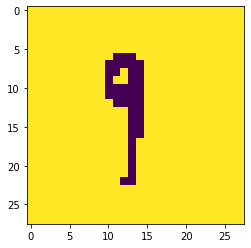

In [96]:
plt.imshow(np.squeeze(train_generator[1][0][30]))

In [102]:
for i in range(5):
  for j in range(5):
    if j==3:
      print(i,j)
      break

0 3
1 3
2 3
3 3
4 3


In [106]:
for i in range(62):
  for sample in train_generator[][1][3]:
    print(sample)

TypeError: ignored